In [95]:
import sys
import pickle
sys.path.insert(0,'./')
import pyccl as ccl
import tracemalloc
from jk_utils import *

# from importlib import reload

In [2]:
import dask
from distributed import LocalCluster
from dask.distributed import Client  # we already had this above
#http://distributed.readthedocs.io/en/latest/_modules/distributed/worker.html
LC=LocalCluster(n_workers=10,processes=False,memory_limit='50gb',threads_per_worker=1,memory_spill_fraction=.99,)
#                memory_monitor_interval='2000ms',worker_memory_limit='50gb')
client=Client(LC)
# dask.config.set(scheduler='single-threaded')

/usr/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [3]:
client

Client Scheduler: inproc://136.152.250.206/30759/1 Dashboard: http://localhost:8787/status,Cluster Workers: 10 Cores: 10 Memory: 500.00 GB


In [4]:
client.restart()

Client Scheduler: inproc://136.152.250.206/30759/1 Dashboard: http://localhost:8787/status,Cluster Workers: 10 Cores: 10 Memory: 500.00 GB


In [5]:
from cov_3X2 import *
# from fisher import *

In [6]:
#only for python3
import importlib
reload=importlib.reload

# Lensing X Lensing Correlation function covariance

## Multiple redshift bins (Tomography)

In [7]:
from lsst_utils import *

In [8]:
import cov_utils
reload(cov_utils)
from cov_utils import *

In [9]:
import window_utils
reload(window_utils)
from window_utils import *

In [10]:
import cov_3X2
reload(cov_3X2)
from cov_3X2 import *
from wigner_transform import *

In [11]:
import hankel_transform
from astropy.io import fits
reload(hankel_transform)
from hankel_transform import *


In [12]:
cosmo_params={'h': 0.8433,
 'Omb': 0.062,
 'Omd': 0.2837-0.062,
 's8': 0.795431,
 'Om': 0.2837,
 'As': 1.685e-09,
 'Ase9': 1.685,
 'mnu': 0.0,
 'Omk': 0.0,
 'tau': 0.06,
 'ns': 0.96859,
 'w': -1,
 'wa': 0,
 'Oml': 1.-0.2837}
PS=Power_Spectra(cosmo_params=cosmo_params)
k,pk,s8=PS.camb_pk(z=[0],cosmo_params=cosmo_params,return_s8=True)
s8

0.7971166457654738

In [13]:
mnu=cosmo_h.m_nu*0
cosmo=cosmo.clone(m_nu=mnu,Ob0=cosmo_params['Omb'],Om0=cosmo_params['Om'])
cosmo_h=cosmo.clone(H0=100) #,m_nu=mnu,Ob0=cosmo_params['Omb'],Om0=cosmo_params['Om'])
ccl_cosmo = ccl.Cosmology(Omega_c=cosmo_params['Omd'], Omega_b=cosmo_params['Omb'], 
                      h=cosmo_params['h'], A_s=cosmo_params['As'], n_s=cosmo_params['ns'],)#m_nu=[0,0,0.06])

In [14]:
use_window=True
do_sample_variance=True
SSV_cov=False
tidal_SSV=True
Tri_cov=False
sigma_gamma=0.3944/sqrt(2.)  #*2**0.25

In [15]:
f_sky=.3 #3000./(4*np.pi/d2r**2)
f_sky

nside=512

In [16]:
f_sky

0.3

In [17]:
zmin=0.3
zmax=2

z=np.linspace(0,5,200)
pzs=lsst_pz_source(z=z)
x=z<zmax
x*=z>zmin
z=z[x]
pzs=pzs[x]

ns0=26 #26+np.inf #ns=inf means shape noise is zero
nbins=1  # Number of tomographic bins
z_sigma=0.03
zs_bins=source_tomo_bins(zp=z,p_zp=pzs,ns=ns0,nz_bins=nbins,use_window=use_window,f_sky=f_sky,window_cl_fact=1,
                         ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),sigma_gamma=sigma_gamma,
                        zp_sigma=z_sigma*np.ones_like(z),nside=nside,)

ng0=10 #26+np.inf #ns=inf means shape noise is zero
nlbins=1 # Number of tomographic bins
z_sigma=0.005
zl_bins=source_tomo_bins(zp=z,p_zp=pzs,ns=ng0,nz_bins=nlbins,use_window=use_window,f_sky=f_sky,
                         ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),window_cl_fact=1,
                        zp_sigma=z_sigma*np.ones_like(z),k_max=1.e6,nside=nside,)
for i in np.arange(nlbins):
    zl_bins[i]['b1']=1

./cov_utils.py:60: RuntimeWarning: invalid value encountered in true_divide
  Win0=2*jn(1,l_th)/l_th
./angular_power_spectra.py:23: RuntimeWarning: divide by zero encountered in true_divide
  self.cl_f=(l+0.5)**2/(l*(l+1.)) # cl correction from Kilbinger+ 2017
/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Win gen: step size 1536
cl dict done


/usr/lib/python3.7/site-packages/healpy/sphtfunc.py:402: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Win gen: step size 1536
cl dict done
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [18]:
for a in ()+("X",):
    print (a)

X


In [19]:
do_cov=True

In [20]:
do_xi=True
bin_xi=True
bin_cl=True
th_min=2.5/60
th_max=250./60
n_th_bins=20
th_bins=np.logspace(np.log10(th_min),np.log10(th_max),n_th_bins+1)
th=np.logspace(np.log10(th_min*0.98),np.log10(1),n_th_bins*30)
th2=np.linspace(1,th_max*1.02,n_th_bins*30)
# th2=np.logspace(np.log10(1),np.log10(th_max),60*6)
th=np.unique(np.sort(np.append(th,th2)))
thb=np.sqrt(th_bins[1:]*th_bins[:-1])

In [21]:
#Hankel Transform setup
l_max=1e3
l_maxW=1e3
l_min=0
# nl=1e2
# nl_bins=np.int(nl/10)
# l0=np.logspace(np.log10(l_min),np.log10(l_maxW),nl)
# l0=np.append([0,1],l0)
# l0=np.unique(np.int32(l0))
# l0_HT=l0
l0=np.arange(l_min,l_max)
l0_HT=np.arange(l_max)
nl_bins=20
  #np.arange(l_min,l_max)
# l0=np.unique(np.int32(np.logspace(np.log10(l_min),np.log10(l_maxW),4.e3)))   #np.arange(l_min,l_max)
# l_bins=np.unique(np.int32(np.logspace(np.log10(l_min),np.log10(l_max),50)))
l_bins=np.unique(np.int32(np.linspace(l_min,l_max,nl_bins)))
lb=0.5*(l_bins[1:]+l_bins[:-1])
prune_theta=0
HT_kwargs={'l_min':l_min,  'l_max':l_max,
                        'theta_min':th_min*d2r*.9, 'theta_max':th_max*d2r,
                        'n_zeros':40000, 'prune_theta':prune_theta, 'm1_m2':[(2,2),(2,-2),(0,2),(0,0)]}
# %time HT=hankel_transform(**HT_kwargs)
# HT_kwargs2={'l_min':l_min,  'l_max':l_max,
#                         'theta_min':th_min*d2r*.9, 'theta_max':th_max*d2r,
#                         'n_zeros':40000, 'prune_theta':2, 'm1_m2':[(2,-2)]}#,(2,-2)]}

In [22]:
power_spectra_kwargs={'cosmo':cosmo,'cosmo_params':cosmo_params,'pk_func':'camb_pk_too_many_z'}

In [23]:
corr_ggl=('shear','galaxy')
corr_ggk=('kappa','galaxy')
corr_gg=('galaxy','galaxy')
corr_ll=('shear','shear')
corr_kk=('kappa','kappa')
m1m2=(0,2)
m1m2_gg=(0,0)

In [24]:
#### Wigner Transform setup... Using high ell to test convergence
WT_L_kwargs={'l': l0_HT,'theta': th*d2r,'m1_m2':[(2,2),(2,-2),(0,2),(2,0),(0,0)]}
%time WT_L=wigner_transform(**WT_L_kwargs)

./wigner_functions.py:38: RuntimeWarning: invalid value encountered in true_divide
  d_mat/=np.sqrt(binom(k+b,b))
./wigner_functions.py:38: RuntimeWarning: divide by zero encountered in true_divide
  d_mat/=np.sqrt(binom(k+b,b))
./wigner_functions.py:38: RuntimeWarning: divide by zero encountered in true_divide
  d_mat/=np.sqrt(binom(k+b,b))


CPU times: user 474 ms, sys: 1.24 s, total: 1.72 s
Wall time: 2.54 s


In [265]:
WT_L.wig_d[(2,2)].shape

(1199, 1000)

array([0.00071268, 0.00071649, 0.00072033, ..., 0.0739871 , 0.0740818 ,
       0.07417649])

4.25


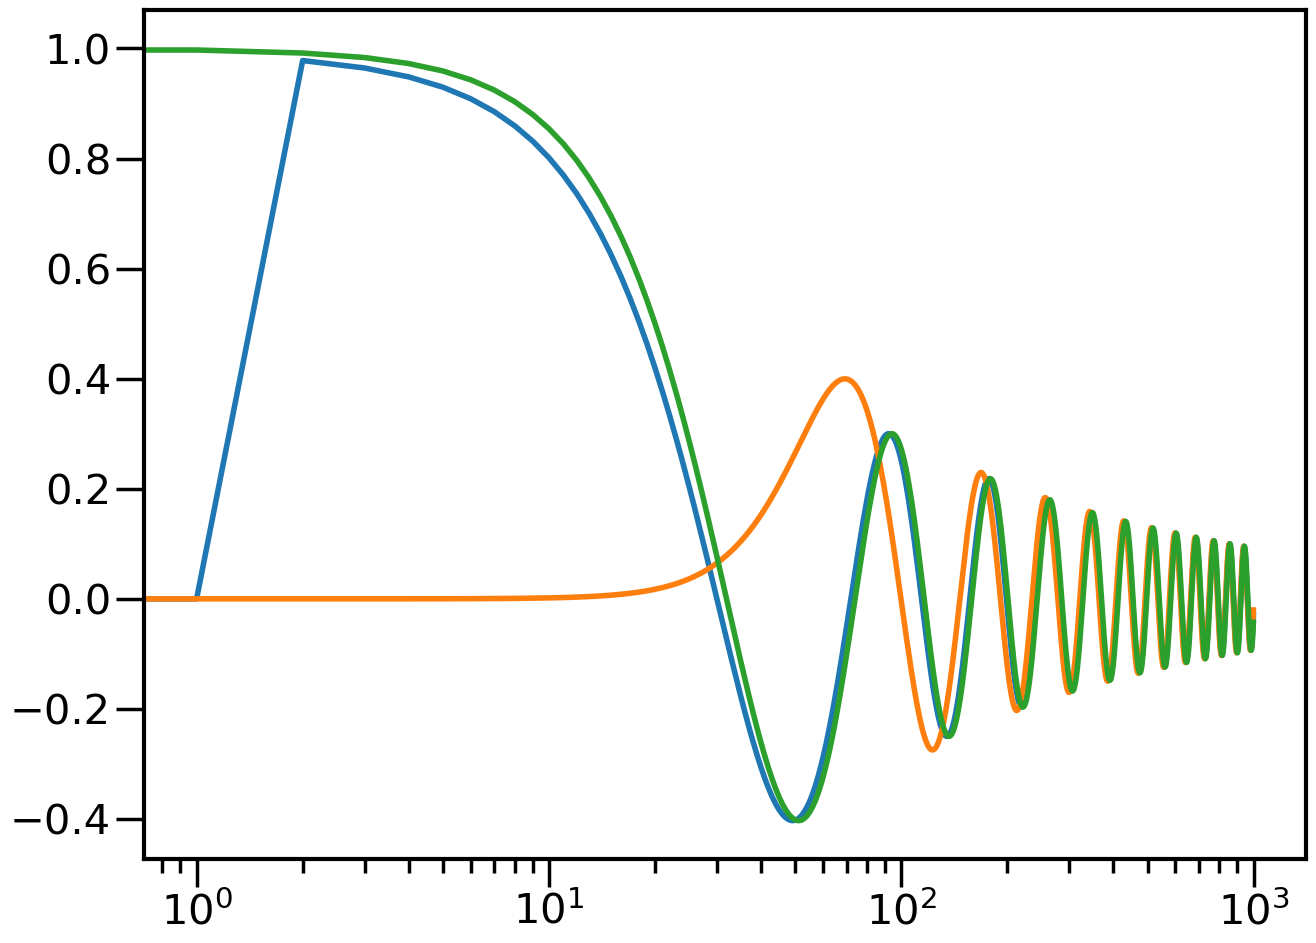

In [278]:
i=1198

print(WT_L.theta[(2,2)][i]*180./np.pi)
plot(WT_L.l,WT_L.wig_d[(2,2)][i,:])
plot(WT_L.l,WT_L.wig_d[(2,-2)][i,:])
plot(WT_L.l,WT_L.wig_d[(0,0)][i,:])
xscale('log')

In [25]:
window_lmax=100
bi=(0,0)



In [26]:
import window_utils
reload(window_utils)
from window_utils import *

import cov_utils
reload(cov_utils)
from cov_utils import *

import cov_3X2
reload(cov_3X2)
from cov_3X2 import *

In [27]:
do_cov=True
use_window=True

In [28]:
wigner_files={}
wigner_files[0]= 'temp/dask_wig3j_l6500_w2100_0_reorder.zarr'
wigner_files[2]= 'temp/dask_wig3j_l3500_w2100_2_reorder.zarr'

In [29]:
tracemalloc.clear_traces()
tracemalloc.start()

t1=time.time()
try:
    Win=XI_W_L.Win.Win
except:
    Win=None
XI_W_L= cov_3X2(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,zg_bins=zl_bins,
                do_sample_variance=do_sample_variance,use_window=use_window,window_lmax=window_lmax,
                power_spectra_kwargs=power_spectra_kwargs,corrs=[corr_ll,corr_gg,corr_ggl]
                ,store_win=True,#Win=Win,
               SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=True,HT=WT_L,f_sky=f_sky,
               bin_xi=bin_xi,theta_bins=th_bins,
               wigner_files=wigner_files)#ns=np.inf)
t2=time.time()
snapshot1 = tracemalloc.take_snapshot()
print('W done',t2-t1)
top_stats = snapshot1.statistics('lineno')

Win gen: step size 1001
wigner_files: {0: 'temp/dask_wig3j_l6500_w2100_0_reorder.zarr', 2: 'temp/dask_wig3j_l3500_w2100_2_reorder.zarr'}
wigner done dict_keys([0, 2])
setting windows <Client: scheduler='inproc://136.152.250.206/30759/1' processes=10 cores=10>
got window cls, now to coupling matrices.
done coupling submatrix  0 8.396579504013062 2.4237585067749023 5.577225923538208
W done 28.75476908683777


In [30]:
XI_W_L_NW= cov_3X2(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,zg_bins=zl_bins, #no window
                do_sample_variance=do_sample_variance,use_window=False,window_lmax=30,
                power_spectra_kwargs=power_spectra_kwargs,corrs=[corr_ll,corr_ggl,corr_gg],store_win=True,
               SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=True,HT=WT_L,f_sky=f_sky,
               bin_xi=bin_xi,theta_bins=th_bins)#ns=np.inf)
print('NW done')
%time clG_nw=XI_W_L_NW.cl_tomo()

Win gen: step size 1001
NW done
added extra corr calc for covariance [('shear', 'shear'), ('shear', 'galaxy'), ('galaxy', 'galaxy'), ('galaxy', 'shear')]
Note: redshifts have been re-sorted (earliest first)
cl dict done
CPU times: user 3.35 s, sys: 20.7 ms, total: 3.37 s
Wall time: 722 ms


In [31]:
%time xiWG_L=XI_W_L.xi_tomo()
%time xiWG_L_nw=XI_W_L_NW.xi_tomo()

added extra corr calc for covariance [('shear', 'shear'), ('galaxy', 'galaxy'), ('shear', 'galaxy'), ('galaxy', 'shear')]
Note: redshifts have been re-sorted (earliest first)
cl dict done
CPU times: user 3.68 s, sys: 20 ms, total: 3.7 s
Wall time: 991 ms
added extra corr calc for covariance [('shear', 'shear'), ('shear', 'galaxy'), ('galaxy', 'galaxy'), ('galaxy', 'shear')]
Note: redshifts have been re-sorted (earliest first)
cl dict done
CPU times: user 3.46 s, sys: 3.38 ms, total: 3.46 s
Wall time: 723 ms


In [32]:
XI_W_L.Win.Win['cov'][corr_ll+corr_ll][bi+bi].keys()

dict_keys(['corr1', 'corr2', 'indxs1', 'indxs2', 1324, 1423, 'f_sky12', 'f_sky34', 'mask_comb_cl', 'Om_w12', 'Om_w34', 'M', 'xi', 'xi_b', 'W_pm', 'm1m2'])

In [33]:
%time xiW_L=xiWG_L['stack'].compute()
%time xiW_L_nw=xiWG_L_nw['stack'].compute()

CPU times: user 29.1 s, sys: 176 ms, total: 29.3 s
Wall time: 4.17 s
[0.00000000e+00 0.00000000e+00 5.17524975e-16 1.13040856e-15
 1.68032642e-15 2.14906656e-15 2.53933739e-15 2.85658190e-15
 3.10708315e-15 3.29843781e-15 3.43759207e-15 3.53116845e-15
 3.58551129e-15 3.60619439e-15 3.59838029e-15 3.56669194e-15
 3.51524633e-15 3.44773188e-15 3.36736366e-15 3.27697710e-15
 3.17904537e-15 3.07568925e-15 2.96875851e-15 2.85980526e-15
 2.75014013e-15 2.64085872e-15 2.53285285e-15 2.42690961e-15
 2.32361101e-15 2.22339193e-15 2.12656931e-15 2.03334974e-15
 1.94391396e-15 1.85838494e-15 1.77680401e-15 1.69915620e-15
 1.62539354e-15 1.55542771e-15 1.48914368e-15 1.42641489e-15
 1.36710222e-15 1.31105762e-15 1.25811593e-15 1.20811101e-15
 1.16088012e-15 1.11626229e-15 1.07409722e-15 1.03422814e-15
 9.96501144e-16 9.60772332e-16 9.26906401e-16 8.94772271e-16
 8.64242517e-16 8.35200433e-16 8.07534104e-16 7.81142912e-16
 7.55932382e-16 7.31812171e-16 7.08697337e-16 6.86512608e-16
 6.65194495e-16 

 1.07772585e-16 1.07554422e-16 1.07337154e-16 1.07120546e-16] [4.79154379e-17 1.45282544e-16 1.07545577e-14 2.05312792e-14
 2.90911838e-14 3.63698607e-14 4.24450134e-14 4.73985744e-14
 5.13167835e-14 5.43183114e-14 5.65060342e-14 5.79787422e-14
 5.88393287e-14 5.91705166e-14 5.90525575e-14 5.85576268e-14
 5.77501090e-14 5.66877448e-14 5.54209971e-14 5.39944411e-14
 5.24470040e-14 5.08120979e-14 4.91189106e-14 4.73919565e-14
 4.56519243e-14 4.39161318e-14 4.21986900e-14 4.05121446e-14
 3.88657455e-14 3.72663217e-14 3.57188492e-14 3.42265927e-14
 3.27925576e-14 3.14188842e-14 3.01063580e-14 2.88547261e-14
 2.76631882e-14 2.65303604e-14 2.54544673e-14 2.44336379e-14
 2.34658153e-14 2.25487997e-14 2.16800673e-14 2.08570647e-14
 2.00772989e-14 1.93383227e-14 1.86376813e-14 1.79729653e-14
 1.73418103e-14 1.67420313e-14 1.61715803e-14 1.56284540e-14
 1.51107133e-14 1.46165849e-14 1.41443560e-14 1.36924946e-14
 1.32595620e-14 1.28441744e-14 1.24450247e-14 1.20609679e-14
 1.16910672e-14 1.13345

CPU times: user 28.9 s, sys: 173 ms, total: 29.1 s
Wall time: 4.14 s


In [34]:
%time clG=XI_W_L.cl_tomo()
# %time cl_L=clG['stack'].compute()

added extra corr calc for covariance [('shear', 'shear'), ('galaxy', 'galaxy'), ('shear', 'galaxy'), ('galaxy', 'shear')]
Note: redshifts have been re-sorted (earliest first)
cl dict done
CPU times: user 3.48 s, sys: 30.9 ms, total: 3.51 s
Wall time: 830 ms


In [35]:
np.arange(1)

array([0])

In [36]:
corr=corr_gg

In [37]:
cl0={'cl':{},'cl_b':{}}
cl0['cl'][corr]=clG_nw['cl'][corr][bi].compute()
cl0['cl_b'][corr]=clG_nw['cl_b'][corr][bi].compute()

cl0_win={'cl':{},'cl_b':{}}
cl0_win['cl'][corr]=clG['cl'][corr][bi].compute()
cl0_win['cl_b'][corr]=clG['cl_b'][corr][bi].compute()



In [38]:
XI_W_L.SN[corr][bi]

array([1.0427849e-08])

In [39]:
bi=(0,0)
local_state = np.random.RandomState(12312)
clg0=clG['cl'][corr][bi].compute()#[:512]
clN0=XI_W_L.SN[corr][bi]*np.ones_like(clg0)#[:256]
cl_map=hp.synfast(clg0,nside=nside,RNG=local_state)#new=True,pol=False)
N_map=hp.synfast(clN0,nside=nside,RNG=local_state)#new=True,pol=False)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


(1, 1000)

11:43:41 WARNING:findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


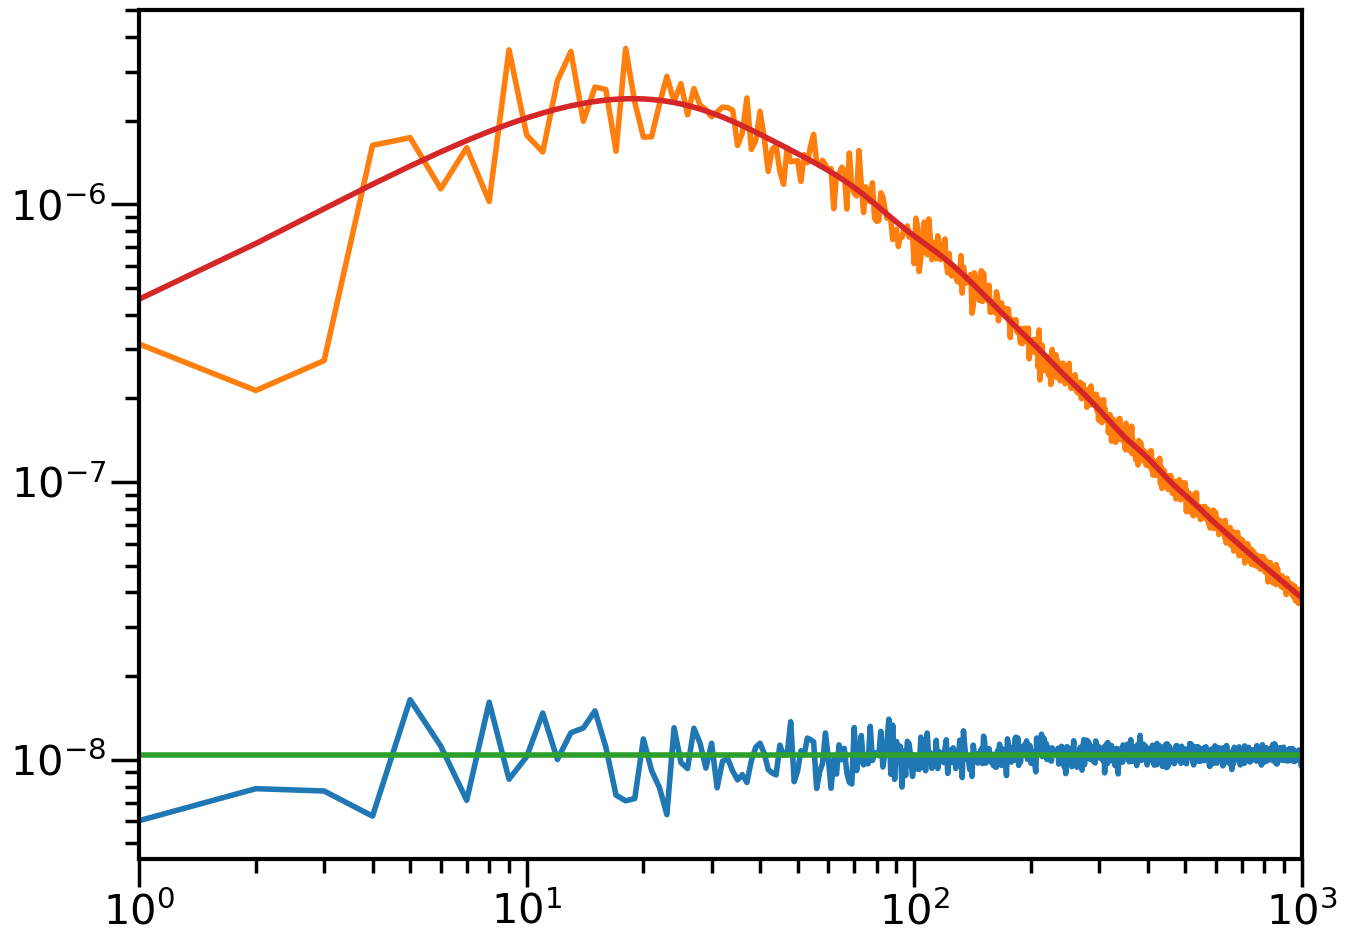

In [40]:
plot(l0,hp.anafast(N_map,lmax=np.int(l0.max())))
plot(l0,hp.anafast(cl_map,lmax=np.int(l0.max())))
plot(l0,clN0)
plot(l0,clg0)
loglog()
xlim(1,1000)

In [99]:
alms_i=hp.map2alm(cl_map)
wf=np.ones(nside*3-1)
wf[3*256-1:]=0
alms_i=hp.sphtfunc.almxfl(alms_i,wf)
cl_i=hp.alm2cl(alms_i)

In [101]:
hp.alm2map

<function healpy.sphtfunc.alm2map(alms, nside, lmax=None, mmax=None, pixwin=False, fwhm=0.0, sigma=None, pol=True, inplace=False, verbose=True)>

In [102]:
map_t=hp.alm2map(alms_i,nside=256)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [109]:
map_t2=hp.ud_grade(cl_map,nside_out=256)

In [110]:
map_t.std(),map_t2.std()

(0.08025632380631102, 0.07775730080460032)

In [233]:
??hp.ud_grade

In [248]:
nt=100
S1=np.zeros(nt)
S2=np.zeros(nt)
S3=np.zeros(nt)
Dt=np.zeros(nt)
clt={}
clt2={}
clt3={}
clt4={}
cl_c={}
Nl=512*3
wf=np.ones(Nl)
wf[3*256:]=0
for i in np.arange(nt):
    cl_map=hp.synfast(clg0,nside=nside,RNG=local_state)#new=True,pol=False)
    alms_i=hp.map2alm(cl_map,lmax=Nl)
    map_t3=hp.alm2map(alms_i,nside=256)
    alms_i2=hp.sphtfunc.almxfl(alms_i,wf)
    map_t2=hp.ud_grade(cl_map,nside_out=256)
    map_t=hp.alm2map(alms_i2,nside=256)
    print((alms_i/alms_i2).mean())
    S1[i]=map_t.std()
    S2[i]=map_t2.std()
    S3[i]=map_t3.std()
    Dt[i]=np.mean((map_t2-map_t2.mean())*(map_t-map_t.mean()))
    
    clt[i]=hp.anafast(map_t)
    clt2[i]=hp.anafast(map_t2)
    clt3[i]=hp.anafast(map_t3)
    clt4[i]=hp.alm2cl(alms_i)
    cl_c[i]=hp.anafast(map_t,map_t2)
Nl=256*3

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
(nan+nanj)


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3.7/site-packages/numpy/core/_methods.py:75: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
(nan+nanj)
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
(nan+nanj)
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
(nan+nanj)
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
(nan+nanj)
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigm

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
(nan+nanj)
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
(nan+nanj)
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
(nan+nanj)
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
(nan+nanj)
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
(nan

(nan+nanj)
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
(nan+nanj)
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
(nan+nanj)
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
(nan+nanj)
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
(nan+nanj)
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 

In [249]:
S1.mean(),S2.mean(),Dt.mean(),S3.mean()

(0.08031182134717628,
 0.07776334573455136,
 0.005908246009095797,
 0.08884834843270749)

In [250]:
alms_i/alms_i2

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([  1. +0.j,   1. -0.j,   1. +0.j, ..., -inf+infj,  inf+infj,
        inf+infj])

In [251]:
R=np.array(list(cl_c.values()))/np.sqrt(np.array(list(clt.values()))*np.array(list(clt2.values())))
R2=np.array(list(clt.values()))/np.array(list(clt2.values()))

(10, 1000)

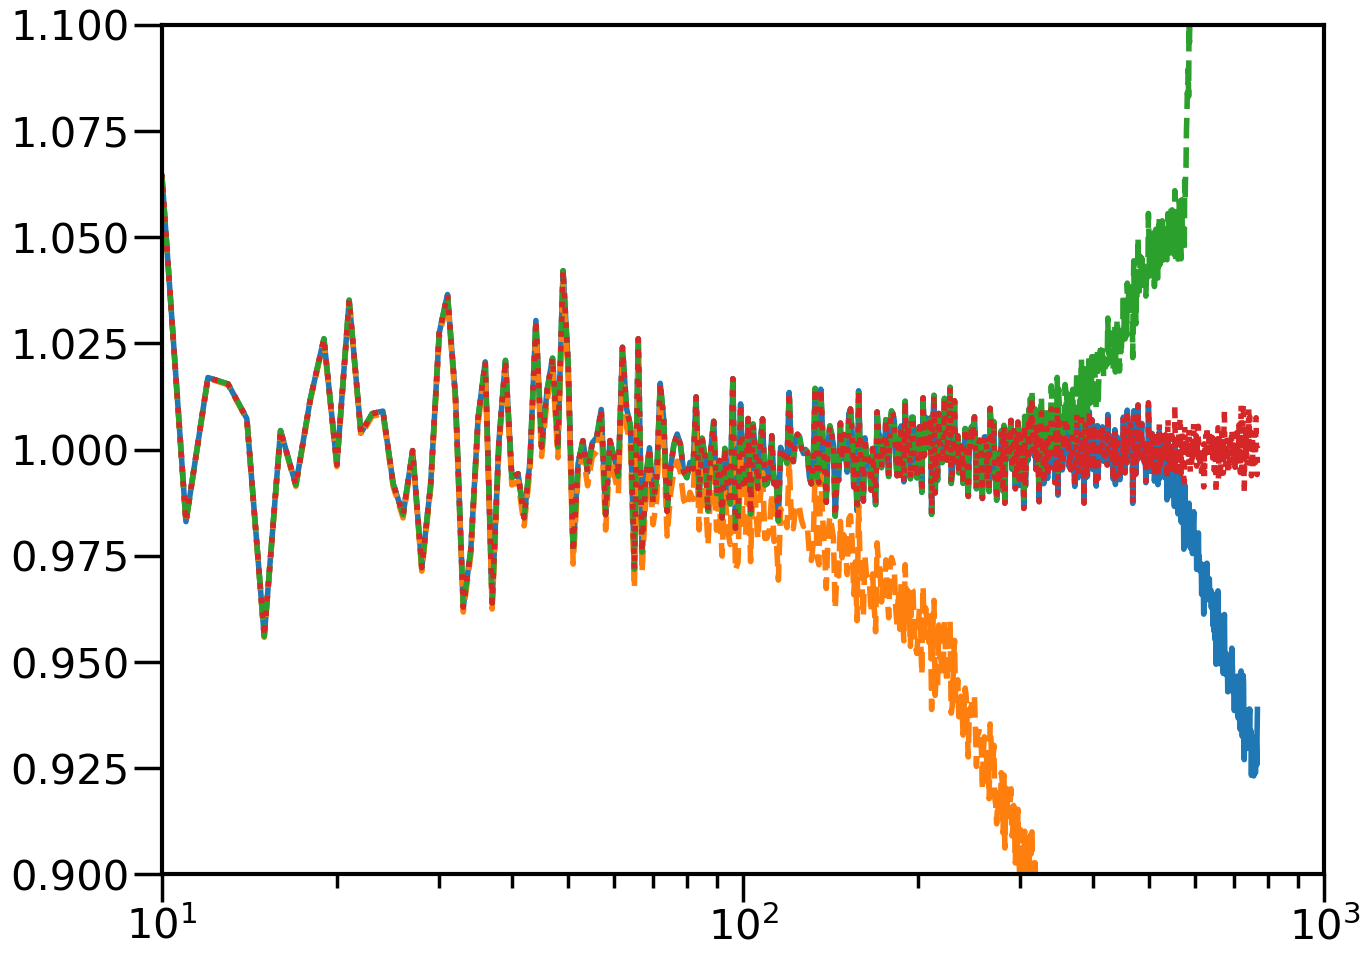

In [252]:
R0=np.array(list(clt.values()))/clg0[:Nl]
R02=np.array(list(clt2.values()))/clg0[:Nl]
R03=np.array(list(clt3.values()))/clg0[:Nl]
R04=np.array(list(clt4.values()))[:,:Nl]/clg0[:Nl]
lt=np.arange(Nl)
plot(lt,R0.mean(axis=0))
plot(lt,R02.mean(axis=0),'--')
plot(lt,R03.mean(axis=0),'--')
plot(lt,R04.mean(axis=0),':')
# plot(lt,wf[:Nl],'--')
xscale('log')
ylim(.9,1.1)
xlim(10,1000)

In [259]:
loggamma(-1)

nan

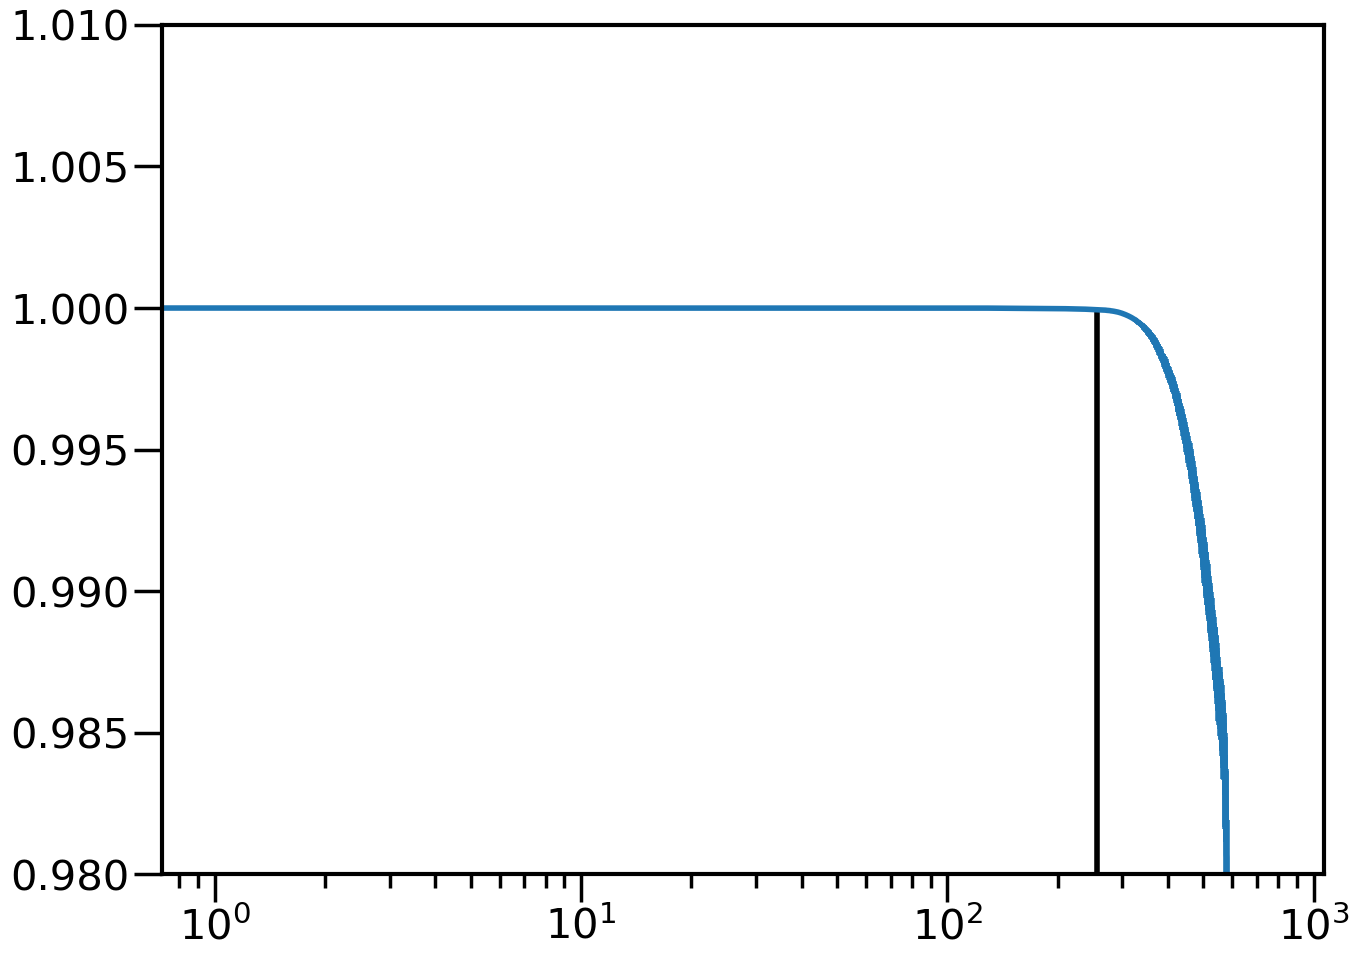

In [253]:
errorbar(np.arange(768),R.mean(axis=0),R.std(axis=0))
xscale('log')
ylim(.98,1.01)
vlines(256,0,1)

(10, 500)

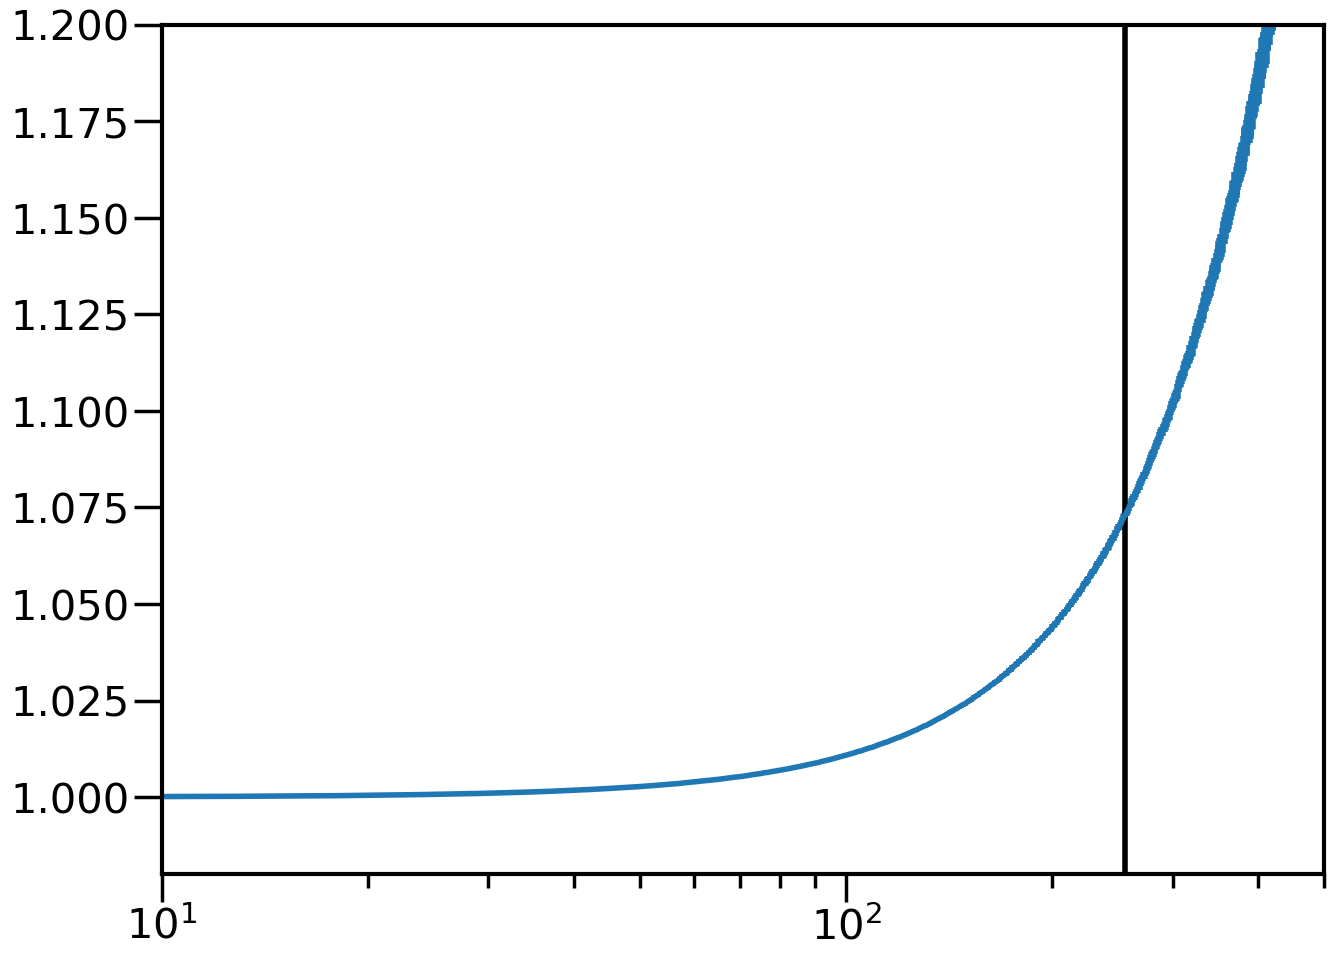

In [254]:
errorbar(np.arange(768),R2.mean(axis=0),R2.std(axis=0))
xscale('log')
ylim(.98,1.2)
vlines(256,0,10)
xlim(10,500)

In [255]:
kappa0=XI_W_L

In [256]:
import binning
reload(binning)
from binning import *
M_binnings={}
M_binning_utils={}

for corr in [corr_gg]:
    M_binnings[corr]=binning()
    wt_b=1./cl0['cl_b'][corr]
    wt0=cl0['cl'][corr]
    M_binning_utils[corr]=M_binnings[corr].bin_utils(r=kappa0.l,r_bins=kappa0.l_bins,
                                                r_dim=2,mat_dims=[1,2],wt_b=wt_b,wt0=wt0)


In [43]:
def corr_matrix(cov_mat=[]): #correlation matrix
    diag=np.diag(cov_mat)
    return cov_mat/np.sqrt(np.outer(diag,diag))
def get_cljk(cl_map,N_map,jk_win):
    x=jk_win>-100
    print(x.mean())
    cl_map_jk=cl_map*jk_win
    N_map_jk=N_map*np.sqrt(jk_win)
    jk_map=cl_map_jk+N_map_jk
    clp=hp.anafast(jk_map,lmax=np.int(l0.max()))
    return clp
#     if ndim>1:
#         for i in np.arange(3):
#             tracer=tracers[i]
#             cl_map[i]*=window[tracer]
#             N_map[i]*=np.sqrt(window[tracer])
#             cl_map[i]+=N_map[i]
#             cl_map[i][mask[tracer]]=hp.UNSEEN
#             N_map[i][mask[tracer]]=hp.UNSEEN

#         clpi=hp.anafast(cl_map, lmax=max(l),pol=True) #TT, EE, BB, TE, EB, TB for polarized input map
#         clpi=clpi[:,l]
#         clpi_B=clpi[[2,4,5],:]
#         clpi=clpi[[0,1,3],:]



In [44]:
njk1=12
njk2=njk1
njk=njk1*njk2

mask=zs_bins[0]['window']>-1000
mask=mask.astype('bool')
jkmap=jk_map(mask=mask,nside=nside,njk1=njk1,njk2=njk2)

In [45]:
jk_corr_indxs={}
jk_corr_indxs[corr]=[(i,i) for i in np.arange(njk2)]

In [46]:
plot(lb,clg_sim[0])
plot(lb,cl0['cl_b'][corr])

NameError: name 'clg_sim' is not defined

In [47]:
top_stats = snapshot1.statistics('traceback')

In [48]:
tracemalloc.get_traced_memory()

(935120291, 8352939951)

In [49]:
stat = top_stats[0]
print("%s memory blocks: %.1f MiB" % (stat.count, stat.size / 1024**2))
for line in stat.traceback.format():
    print(line)

62 memory blocks: 340.0 MiB
  File "/usr/lib/python3.7/site-packages/numpy/core/numeric.py", line 1393
    res = dot(at, bt)


In [50]:
dask.visualize(XI_W_L.Win.Win_cl)

AttributeError: 'window_utils' object has no attribute 'Win_cl'

In [51]:
dask.visualize(XI_W_L.Win.Win_cov)

AttributeError: 'window_utils' object has no attribute 'Win_cov'

In [52]:
crash

NameError: name 'crash' is not defined

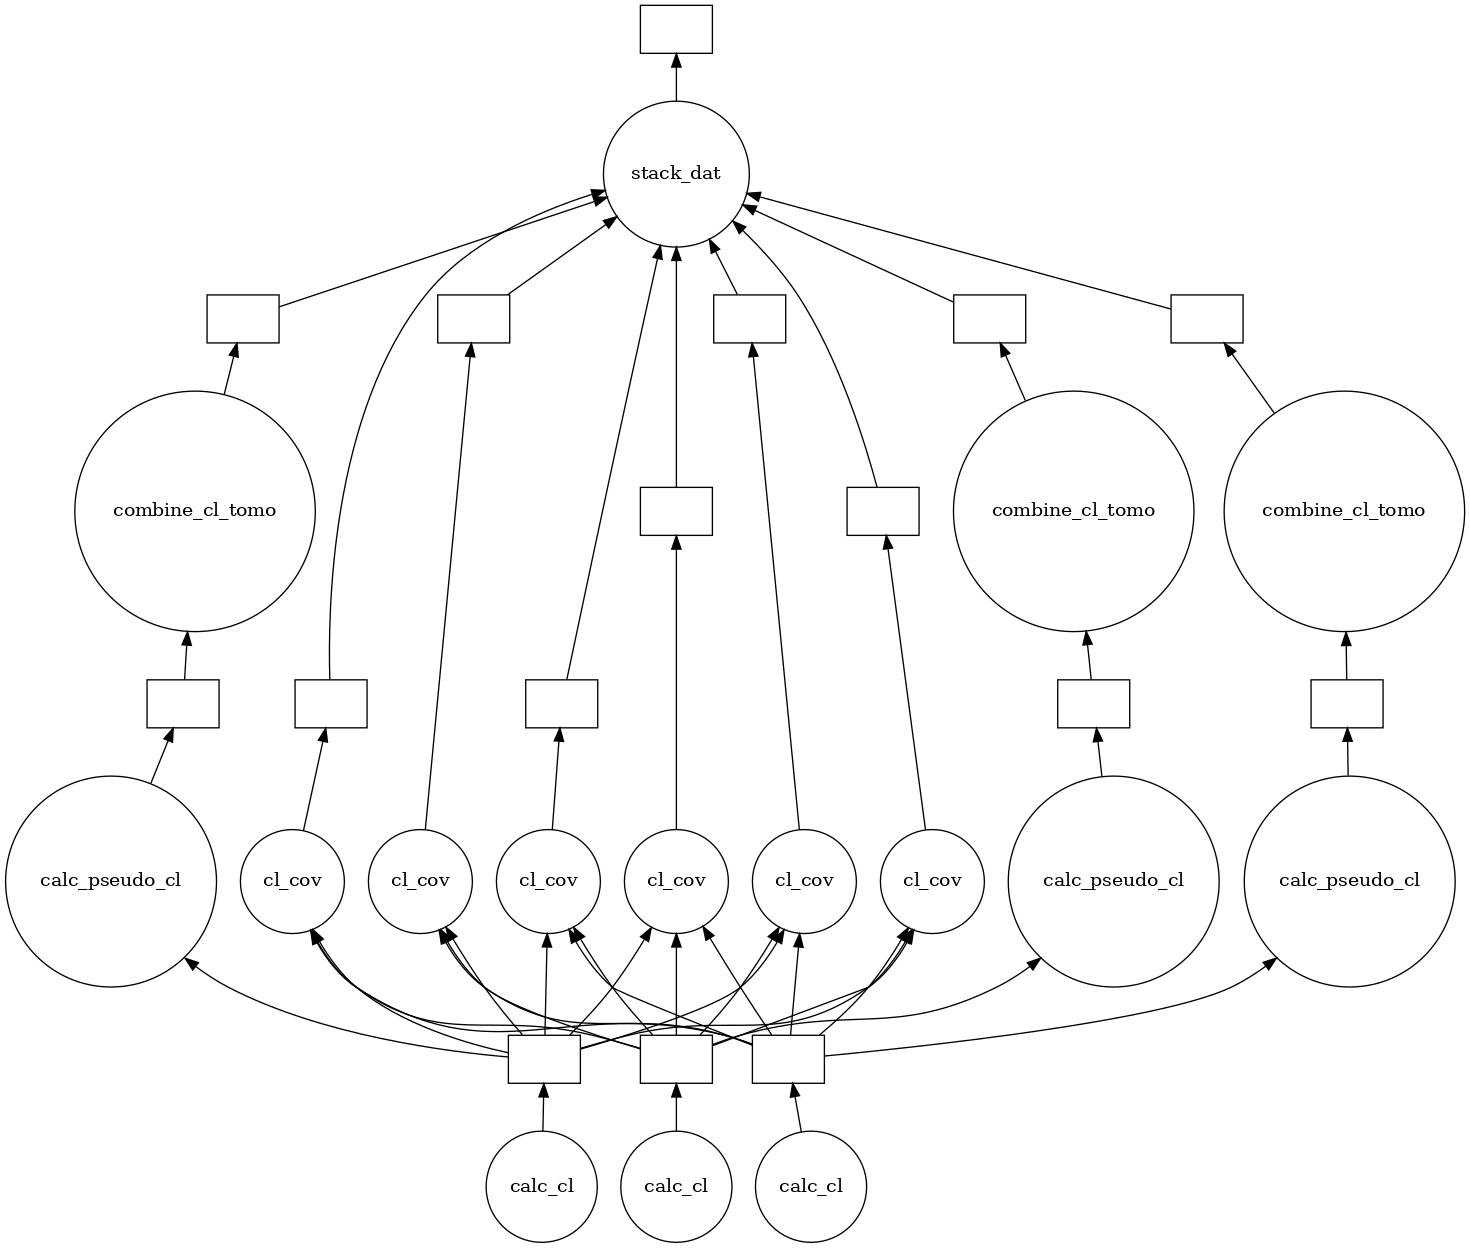

In [53]:
clG['stack'].visualize()

In [54]:
cl=clG['cl'][corr_ll][bi].compute()
pcl=clG['cl_b'][corr_ll][bi].compute()

In [55]:
lb=0.5*(XI_W_L.l_bins[1:]+XI_W_L.l_bins[:-1])

[]

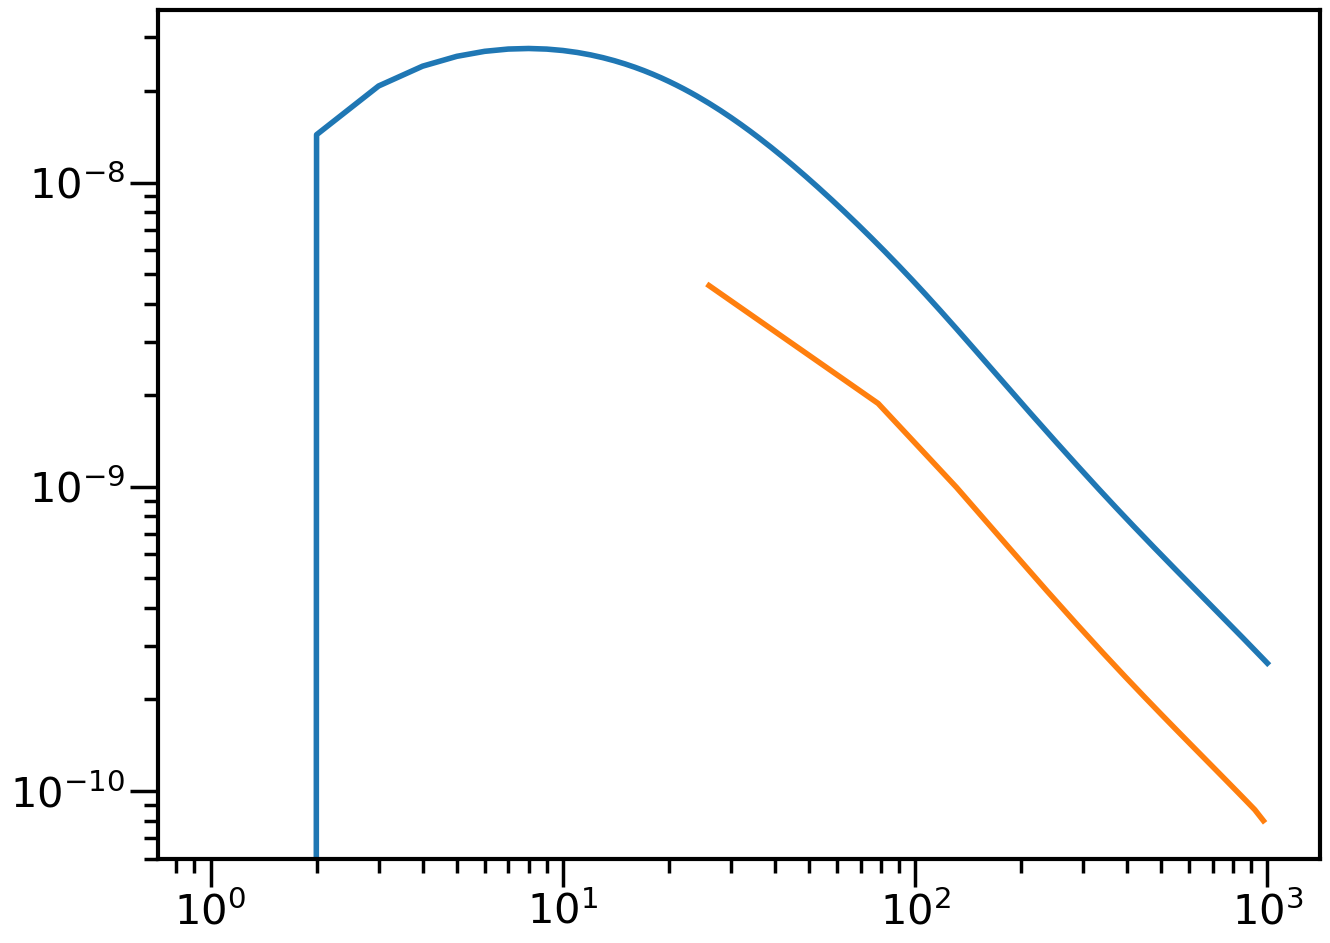

In [56]:
plot(XI_W_L.l,cl)
plot(lb,pcl)
loglog()

In [57]:
A=np.int8(np.eye(1000))
X=np.float32(np.eye(1000))

In [58]:
A

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int8)

In [59]:
B=A.astype('bool')

In [60]:
%time x1=X*A
%time x2=X*B

CPU times: user 4.43 ms, sys: 0 ns, total: 4.43 ms
Wall time: 1.99 ms
CPU times: user 4.44 ms, sys: 0 ns, total: 4.44 ms
Wall time: 2.22 ms


In [61]:
np.all(x1==x2)

True

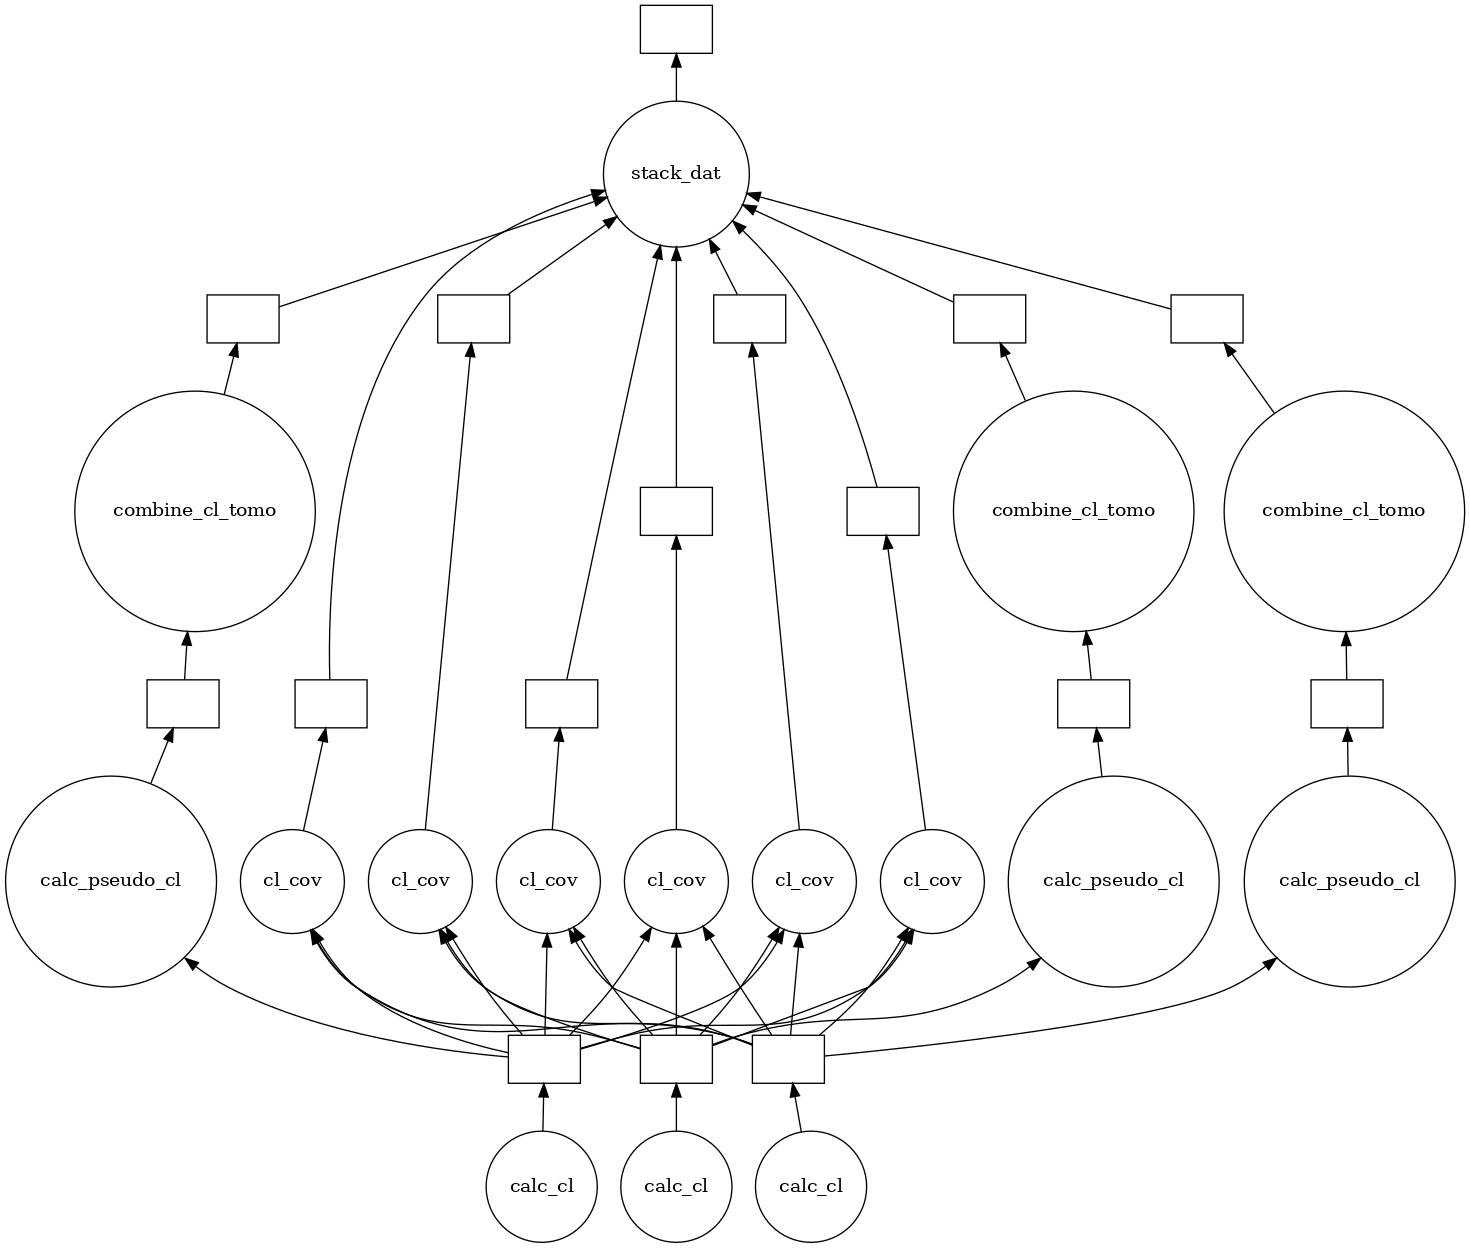

In [62]:
dask.visualize(clG['stack'])

In [63]:
np.arange(1000,step=300)

array([  0, 300, 600, 900])

In [64]:
XI_W_L.Win.Win['cl'][corr_ll][bi]

{'corr': ('shear', 'shear'),
 'indxs': (0, 0),
 12: {'cl': array([1.13097237e+00, 5.54098517e-01, 8.86162559e-02, 1.38931449e-03,
         1.95740143e-02, 4.25909979e-03, 1.51678667e-03, 4.36214032e-03,
         3.22647044e-04, 1.16864977e-03, 1.35770191e-03, 4.85850308e-07,
         7.82242644e-04, 4.04456593e-04, 6.41405079e-05, 4.92084940e-04,
         9.34309317e-05, 1.29549434e-04, 2.68880530e-04, 5.96680171e-06,
         1.56205400e-04, 1.31180468e-04, 5.45185629e-06, 1.37715060e-04,
         4.83059550e-05, 2.57972881e-05, 9.79177885e-05, 8.93677669e-06,
         4.55020758e-05, 6.11467248e-05, 5.71271426e-07, 4.91305007e-05,
         2.73215490e-05, 6.56064948e-06, 4.50009593e-05, 8.52618789e-06,
         1.63152000e-05, 3.35622187e-05, 1.02110858e-06, 2.12320237e-05,
         1.80845357e-05, 1.64808471e-06, 2.36110468e-05, 7.92352401e-06,
         5.96402499e-06, 1.94799609e-05, 1.71016439e-06, 1.08816587e-05,
         1.36640807e-05, 3.78234989e-07, 1.26856980e-05, 6.84756439

In [65]:
XI_W_L.Win.Win['cl'][corr_ll][bi]['M_B_noise']

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.18798154, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.1010479 , 0.06725898,
        0.01587848],
       [0.        , 0.        , 0.        , ..., 0.06732641, 0.10104789,
        0.06725901],
       [0.        , 0.        , 0.        , ..., 0.01591031, 0.06732637,
        0.10104789]])

In [66]:
# M2=XI_W_L.Win.Win['cov'][corr_ll+corr_ll][bi+bi]['M1324'][2].compute()
try:
    M2n=XI_W_L.Win.Win['cl'][corr_ll][bi]['M_B'].compute()
except:
    M2n=XI_W_L.Win.Win['cl'][corr_ll][bi]['M_B']
XI_W_L.SN[corr_ll][:,0,0]@M2n

array([0.00000000e+00, 0.00000000e+00, 9.32000474e-11, 9.32000489e-11,
       9.32000521e-11, 9.32000499e-11, 9.32000506e-11, 9.32000482e-11,
       9.32000468e-11, 9.32000456e-11, 9.32000476e-11, 9.32000479e-11,
       9.32000477e-11, 9.32000453e-11, 9.32000454e-11, 9.32000499e-11,
       9.32000514e-11, 9.32000480e-11, 9.32000467e-11, 9.32000460e-11,
       9.32000512e-11, 9.32000502e-11, 9.32000498e-11, 9.32000506e-11,
       9.32000527e-11, 9.32000514e-11, 9.32000465e-11, 9.32000459e-11,
       9.32000453e-11, 9.32000477e-11, 9.32000529e-11, 9.32000489e-11,
       9.32000496e-11, 9.32000497e-11, 9.32000510e-11, 9.32000486e-11,
       9.32000500e-11, 9.32000495e-11, 9.32000505e-11, 9.32000473e-11,
       9.32000470e-11, 9.32000472e-11, 9.32000477e-11, 9.32000495e-11,
       9.32000495e-11, 9.32000490e-11, 9.32000522e-11, 9.32000470e-11,
       9.32000485e-11, 9.32000458e-11, 9.32000456e-11, 9.32000487e-11,
       9.32000492e-11, 9.32000512e-11, 9.32000469e-11, 9.32000455e-11,
      

[]

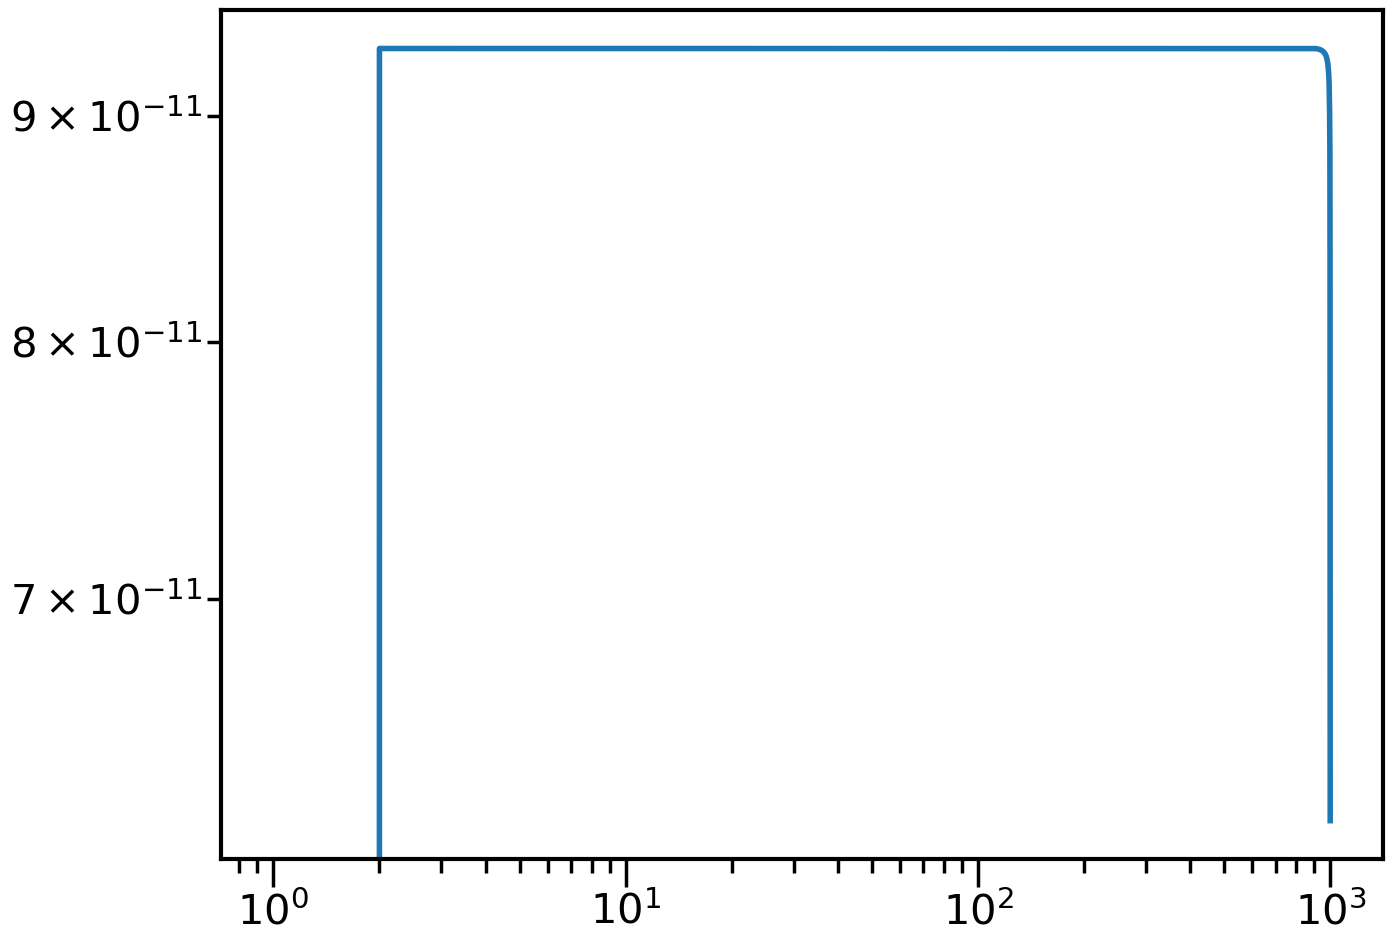

In [67]:
bi=(0,0)
f=1#XI_W_L.l**2
# plot(XI_W_L.l,f*(XI_W_L.SN[corr_ll][:,0,0]@XI_W_L.Win.Win['cov'][corr_ll+corr_ll][bi+bi]['M1324'][2]))
plot(XI_W_L.l,f*(XI_W_L.SN[corr_ll][:,0,0]@M2n))
loglog()

In [68]:
xx=np.random.uniform(0,1,size=(1000,100,3000,)).astype('float64')
xx2=xx.reshape(100,3000,1000)
xx3=xx2.astype('int8')
A=np.ones(1000)

In [69]:
A2=np.int32(A)

In [70]:
# %time clG=XI_W_L.cl_tomo()
%time clG_nw=XI_W_L_NW.cl_tomo()
#%time clH=XI_H.cl_tomo()

added extra corr calc for covariance [('shear', 'shear'), ('shear', 'galaxy'), ('galaxy', 'galaxy'), ('galaxy', 'shear')]
Note: redshifts have been re-sorted (earliest first)


/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


cl dict done
CPU times: user 3.34 s, sys: 9.58 ms, total: 3.35 s
Wall time: 701 ms


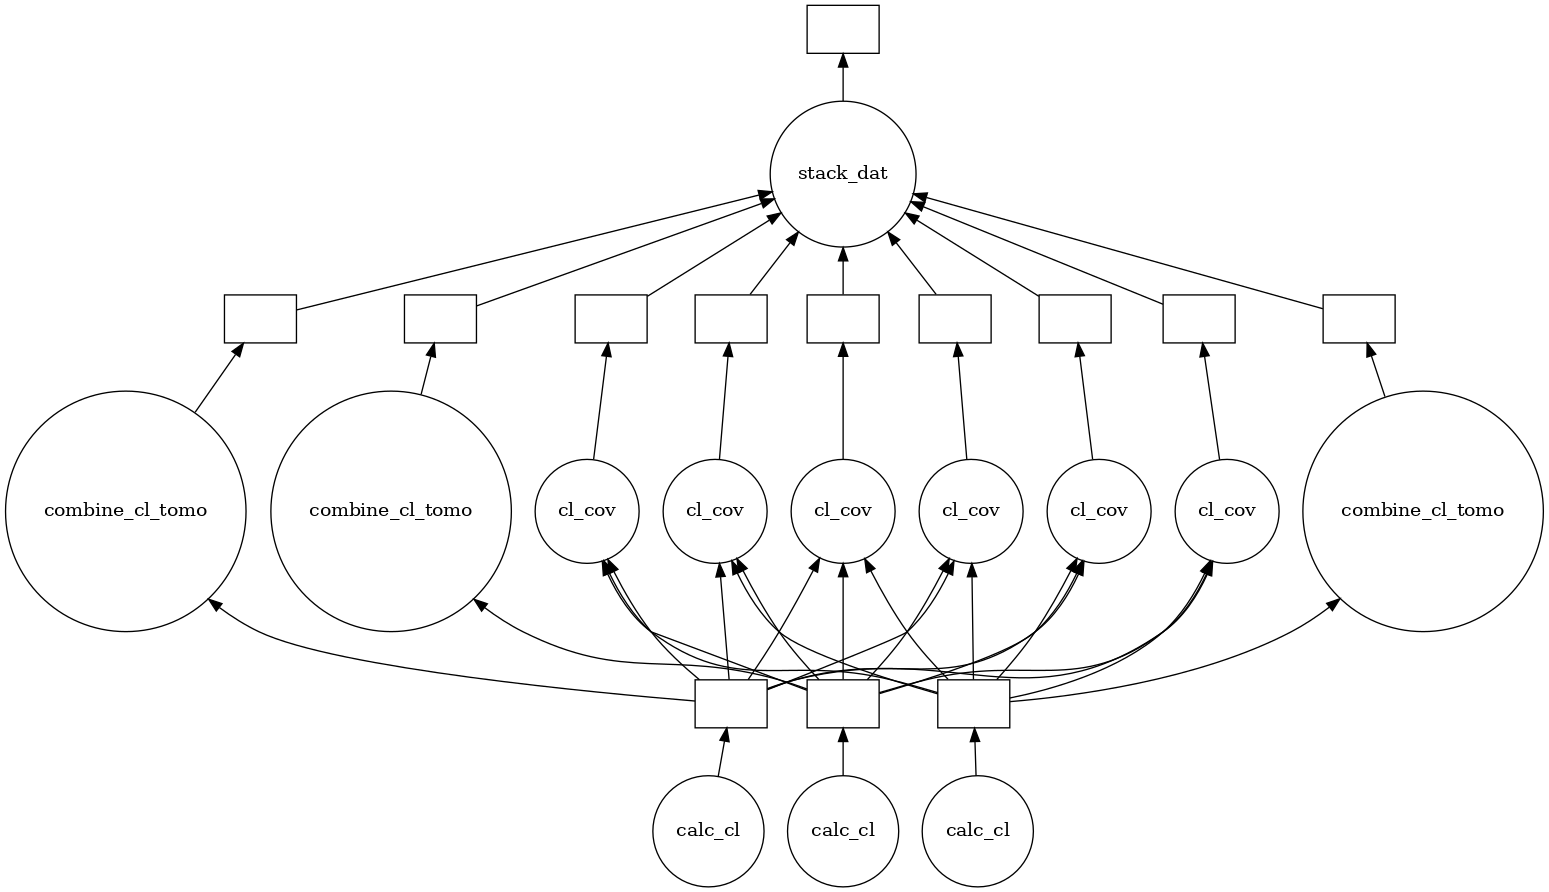

In [71]:
clG_nw['stack'].visualize()

In [72]:
%time cl_L_nw=clG_nw['stack'].compute()

[0.00000000e+00 0.00000000e+00 1.24310165e-15 2.87450568e-15
 4.72476142e-15 6.67294774e-15 8.64358730e-15 1.05716360e-14
 1.24028744e-14 1.41027709e-14 1.56436447e-14 1.70070088e-14
 1.81838321e-14 1.91690862e-14 1.99640008e-14 2.05739626e-14
 2.10078185e-14 2.12770205e-14 2.13948836e-14 2.13759798e-14
 2.12356299e-14 2.09892427e-14 2.06522985e-14 2.02394706e-14
 1.97647985e-14 1.92410715e-14 1.86802728e-14 1.80937236e-14
 1.74909408e-14 1.68800877e-14 1.62677839e-14 1.56594886e-14
 1.50605391e-14 1.44753540e-14 1.39071978e-14 1.33585598e-14
 1.28312174e-14 1.23262335e-14 1.18442041e-14 1.13854607e-14
 1.09499552e-14 1.05373098e-14 1.01468334e-14 9.77774666e-15
 9.42913158e-15 9.09994104e-15 8.78907146e-15 8.49541580e-15
 8.21781044e-15 7.95512291e-15 7.70621458e-15 7.46999553e-15
 7.24539873e-15 7.03143426e-15 6.82709842e-15 6.63145993e-15
 6.44367962e-15 6.26295443e-15 6.08852981e-15 5.91974696e-15
 5.75606576e-15 5.59705423e-15 5.44231328e-15 5.29152678e-15
 5.14443288e-15 5.000785

[1.94607869e-19 1.94607869e-19 2.15552009e-16 4.44634088e-16
 5.97692952e-16 6.92218279e-16 7.46110982e-16 7.71979740e-16
 7.78462499e-16 7.71555062e-16 7.55486443e-16 7.33274477e-16
 7.07093009e-16 6.78514513e-16 6.48681767e-16 6.18417246e-16
 5.88304819e-16 5.58768340e-16 5.30090279e-16 5.02463933e-16
 4.76011109e-16 4.50797909e-16 4.26854989e-16 4.04183276e-16
 3.82760994e-16 3.62558135e-16 3.43526098e-16 3.25618483e-16
 3.08780992e-16 2.92955479e-16 2.78088275e-16 2.64123242e-16
 2.51004756e-16 2.38681769e-16 2.27104392e-16 2.16223282e-16
 2.05993914e-16 1.96374241e-16 1.87323806e-16 1.78804120e-16
 1.70780056e-16 1.63219782e-16 1.56092345e-16 1.49368120e-16
 1.43020610e-16 1.37025827e-16 1.31360868e-16 1.26003777e-16
 1.20934179e-16 1.16133660e-16 1.11585956e-16 1.07275068e-16
 1.03185506e-16 9.93032039e-17 9.56153833e-17 9.21108658e-17
 8.87785855e-17 8.56079139e-17 8.25887973e-17 7.97121193e-17
 7.69698997e-17 7.43548922e-17 7.18595785e-17 6.94771357e-17
 6.72007438e-17 6.502451

CPU times: user 893 ms, sys: 55.9 ms, total: 949 ms
Wall time: 554 ms


In [73]:
clG['cl'].keys()

dict_keys([('shear', 'shear'), ('galaxy', 'galaxy'), ('shear', 'galaxy'), ('galaxy', 'shear')])

In [74]:
bi=(0,0)
corr=corr_ggl
cov_t=clG['cov'][corr+corr][(0,0,0,0)].compute()
cl_bt=clG['cl_b'][corr][(0,0)].compute()
cl_btnw=clG_nw['cl_b'][corr][(0,0)].compute()
cov_tnw=clG_nw['cov'][corr+corr][(0,0,0,0)].compute()

[4.79154379e-17 1.45282544e-16 1.07545577e-14 2.05312792e-14
 2.90911838e-14 3.63698607e-14 4.24450134e-14 4.73985744e-14
 5.13167835e-14 5.43183114e-14 5.65060342e-14 5.79787422e-14
 5.88393287e-14 5.91705166e-14 5.90525575e-14 5.85576268e-14
 5.77501090e-14 5.66877448e-14 5.54209971e-14 5.39944411e-14
 5.24470040e-14 5.08120979e-14 4.91189106e-14 4.73919565e-14
 4.56519243e-14 4.39161318e-14 4.21986900e-14 4.05121446e-14
 3.88657455e-14 3.72663217e-14 3.57188492e-14 3.42265927e-14
 3.27925576e-14 3.14188842e-14 3.01063580e-14 2.88547261e-14
 2.76631882e-14 2.65303604e-14 2.54544673e-14 2.44336379e-14
 2.34658153e-14 2.25487997e-14 2.16800673e-14 2.08570647e-14
 2.00772989e-14 1.93383227e-14 1.86376813e-14 1.79729653e-14
 1.73418103e-14 1.67420313e-14 1.61715803e-14 1.56284540e-14
 1.51107133e-14 1.46165849e-14 1.41443560e-14 1.36924946e-14
 1.32595620e-14 1.28441744e-14 1.24450247e-14 1.20609679e-14
 1.16910672e-14 1.13345320e-14 1.09905659e-14 1.06584986e-14
 1.03377010e-14 1.002761

[]

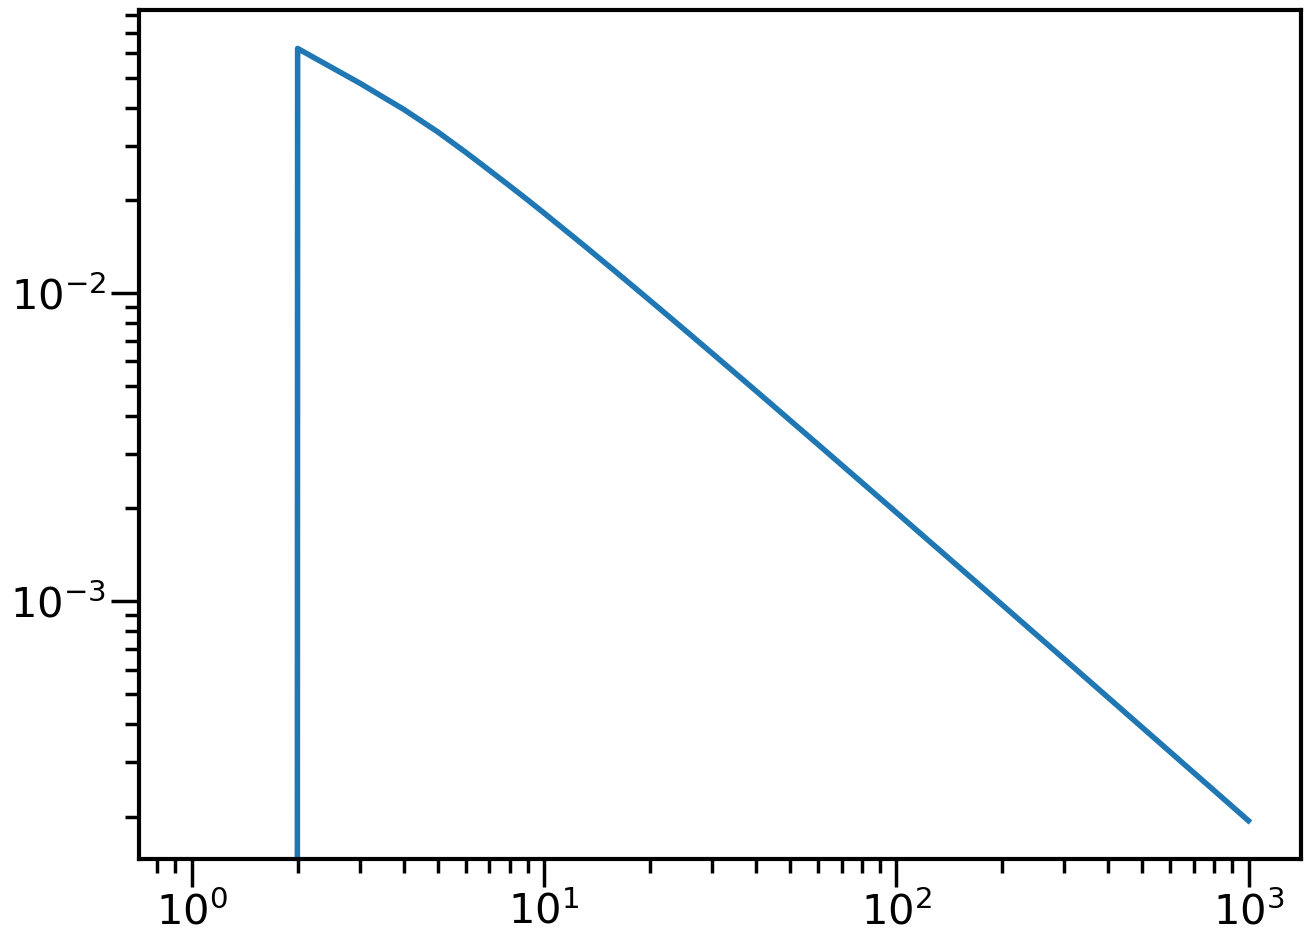

In [75]:
nn='G1324'
plot(np.diag(cov_t[nn])/np.diag(cov_tnw[nn]))
loglog()

[]

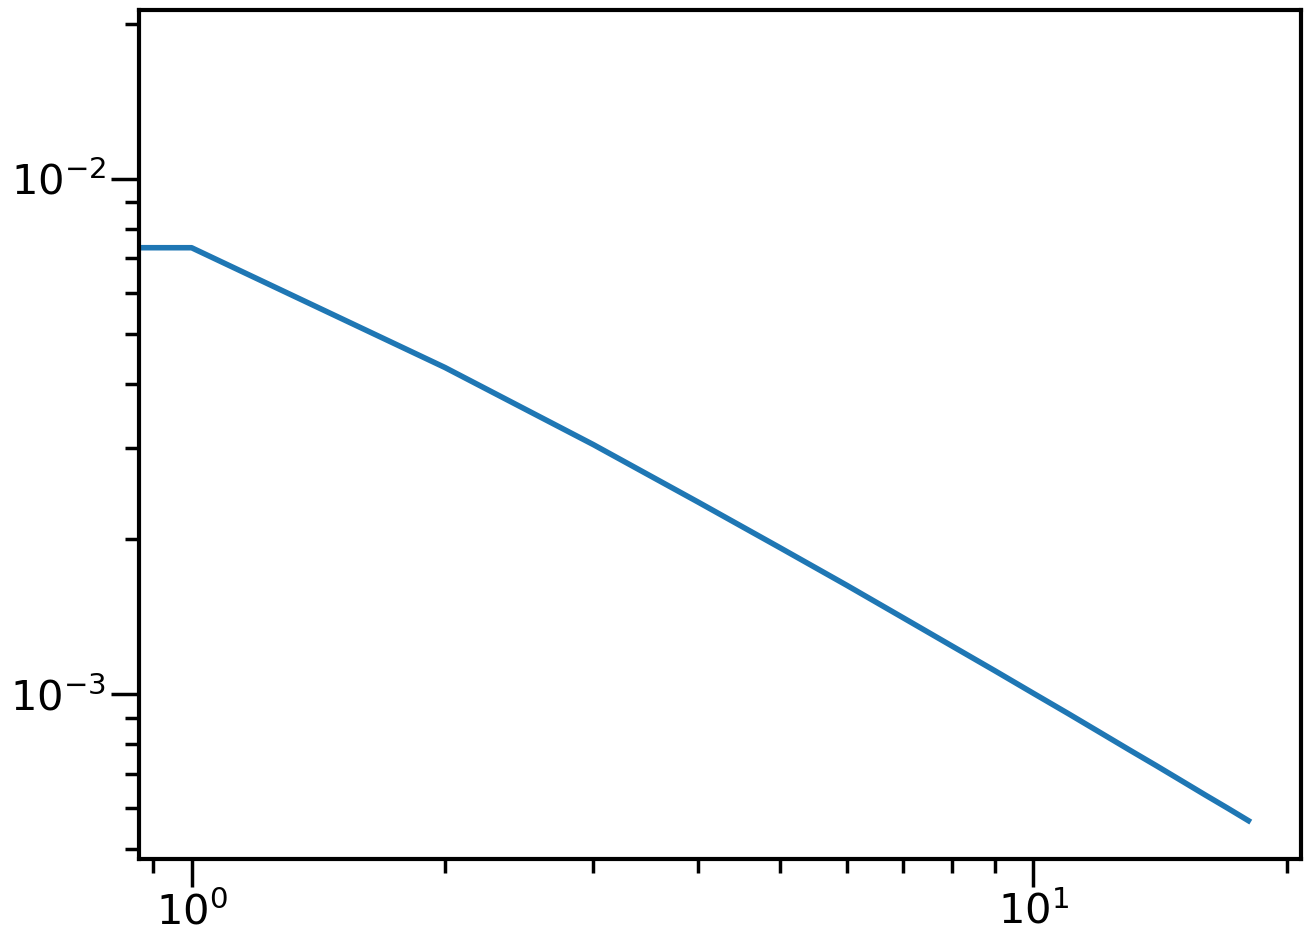

In [79]:
plot(np.diag(cov_t['final_b'])/np.diag(cov_tnw['final_b']))
loglog()

In [77]:
crash

NameError: name 'crash' is not defined

In [81]:
f_sky

0.3

[]

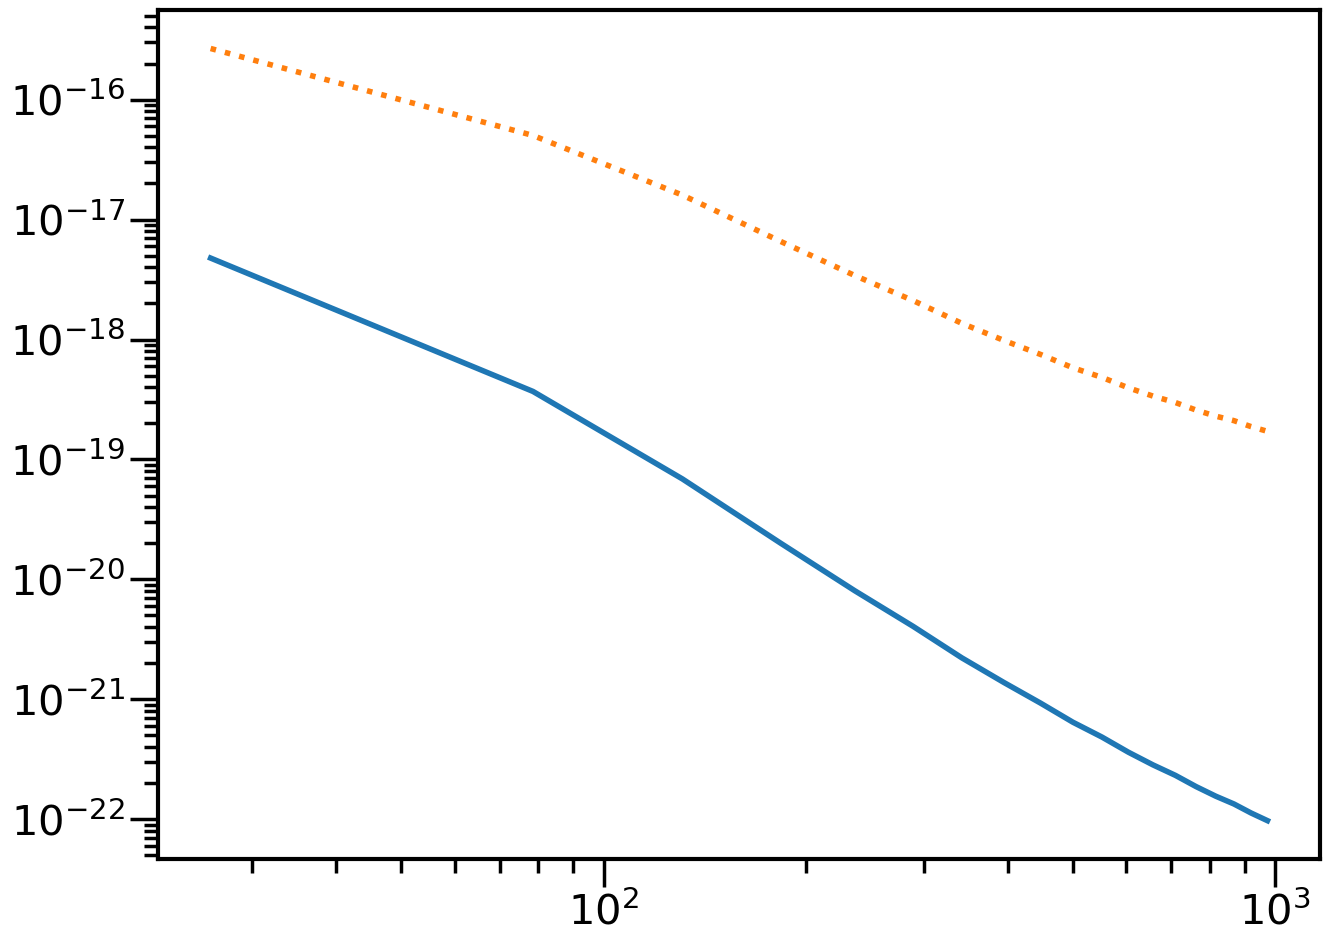

In [93]:
plot(lb,np.diag(cov_t['final_b'])*lb)
# plot(cl_bt**2)
plot(lb,np.diag(cov_tnw['final_b']),':')
# plot(cl_btnw**2,':')
loglog()

In [ ]:
cc=XI_W_L.cov_utils
corrW=cc.corr_matrix(cov_t['final_b'])
corrW-=np.diag(np.diag(corrW))
pcolor(corrW,vmin=-.1,vmax=.1,cmap='seismic')
xticks([])
yticks([])
colorbar()
show()



In [ ]:
cc=XI_W_L.cov_utils
corrW=cc.corr_matrix(cl_L_nw['cov'])
pcolor(corrW,vmin=-1,vmax=1,cmap='seismic')
xticks([])
yticks([])
colorbar()
show()


In [ ]:
XI_W_L.Win.Win['cov'][(corr_ll+corr_ll)][bi+bi]['Om_w'],XI_W_L_NW.cov_utils.Om_W

In [ ]:
plot(XI_W_L.Win.Win['cov'][(corr_ll+corr_ll)][bi+bi]['mask_comb_cl'])
plot(XI_W_L_NW.cov_utils.Win)
yscale('log')

In [ ]:
XI_W_L_NW.f_sky

In [ ]:
XI_W_L_NW.cov_utils.Win

In [ ]:
cc=XI_W_L.cov_utils
corrW=cc.corr_matrix(cl_L['cov'])
pcolor(corrW,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('Wigner')
# hlines(60,0,120)
# vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

In [ ]:
linalg.cond(cl_L['cov']) #< 1/sys.float_info.epsilon

In [ ]:
N=np.linalg.norm(cl_L['cov'])
np.linalg.det(cl_L['cov']*5.e20)

In [ ]:
cov_inv=np.linalg.inv(cl_L['cov'])
cov_nw_inv=np.linalg.inv(cl_L_nw['cov'])
SN=cl_L['cl_b']@cov_inv@cl_L['cl_b']
SN_nw=cl_L_nw['cl_b']@cov_nw_inv@cl_L_nw['cl_b']
SN,SN_nw,SN/SN_nw

In [ ]:
%time xiWG_L=XI_W_L.xi_tomo()
%time xiWG_L_nw=XI_W_L_NW.xi_tomo()

%time xiW_L=xiWG_L['stack'].compute()
%time xiW_L_nw=xiWG_L_nw['stack'].compute()

In [ ]:
%time xiW_L=xiWG_L['stack'].compute()
%time xiW_L_nw=xiWG_L_nw['stack'].compute()

In [ ]:
XI_W_L.corrs

In [ ]:
XI_W_L.Win.Win.keys()

In [ ]:
f=1
xiW_L_nw_inv=np.linalg.inv(xiW_L_nw['cov']*f)
print ((np.dot(xiW_L_nw['xi'],np.dot(xiW_L_nw_inv,xiW_L_nw['xi']))))

cov_xiWL_inv=np.linalg.inv(xiW_L['cov']*f)
print ((np.dot(xiW_L['xi'],np.dot(cov_xiWL_inv,xiW_L['xi']))))

In [ ]:
pcolor(xiW_L_nw['cov']/xiW_L['cov'])
colorbar()

In [ ]:
pcolor(xiW_L_nw_inv/cov_xiWL_inv)
colorbar()

In [ ]:
cc=XI_W_L.cov_utils
corrW=cc.corr_matrix(cl_L['cov'])
pcolor(corrW,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('$C_\ell$')
# hlines(60,0,120)
# vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

In [ ]:
cc=XI_W_L.cov_utils
corrW=cc.corr_matrix(cl_L_nw['cov'])
pcolor(corrW,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('$C_\ell$-NW')
# hlines(60,0,120)
# vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

In [ ]:
R=np.diag(cl_L_nw['cov']/cl_L['cov'])
plot(R)

In [ ]:
cc=XI_W_L.cov_utils
corrW=cc.corr_matrix(xiW_L['cov'])
pcolor(corrW,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('Wigner-W')
# hlines(60,0,120)
# vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

In [ ]:
cc=XI_W_L.cov_utils
corrNW=cc.corr_matrix(xiW_L_nw['cov'])
pcolor(corrNW,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('Wigner-NW')
# hlines(60,0,120)
# vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

In [ ]:
pcolor(corrW/corrNW-1,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('Wigner')
# hlines(60,0,120)
# vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

In [ ]:
XI_W_L.cov_utils.gaussian_cov_norm_2D

In [ ]:
np.diag(xiW_L_nw['cov'])/np.diag(xiW_L['cov'])

In [ ]:
5.25/1.93

In [ ]:
x=np.array([1,0.5,0.1,0.3,0.7])
plot(x,[1,1.93,5.25,2.85,1.37],'bo')
plot(x,1./x,'ro')
yscale('log')
xscale('log')

In [ ]:
xiW_L_nw['cov']/xiW_L['cov']

In [ ]:
xiW_L_nw['xi']/xiW_L['xi']